In [6]:
from qiime2 import Visualization, Artifact, Metadata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [2]:
%cd "/Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101"

/Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101


# Create Input Data

## Drop repeated samples

In [27]:
! qiime feature-table filter-samples \
--i-table noMito_noChloro-filtered-table.qza \
--m-metadata-file Categorical-meta-noNA.tsv \
--o-filtered-table noMito_noChloro-noNA-table.qza

Saved FeatureTable[Frequency] to: noMito_noChloro-noNA-table.qza


## Add taxonomy to feature table

In [28]:
! qiime taxa collapse \
--i-table noMito_noChloro-noNA-table.qza \
--i-taxonomy taxonomy-silva.qza --p-level 7 \
--o-collapsed-table tax-table.qza

Saved FeatureTable[Frequency] to: tax-table.qza


## Load in feature table, make sure index lines up

In [251]:
tax_df = Artifact.load("tax-table.qza")
tax_df = tax_df.view(pd.DataFrame)
tax_df.columns = ["|".join(x.split(";")) for x in tax_df.columns]

In [30]:
mapping = pd.read_csv("Categorical-meta-noNA.tsv", sep="\t",
                     index_col="sampleid")
mapping = mapping[mapping.iloc[:,1].isna()==False]

In [252]:
print(len(tax_df.index))
print(tax_df.index.dtype)

print(len(mapping.index))
print(mapping.index.dtype)

33
object
33
float64


In [253]:
tax_df.index = tax_df.index.astype(float)

#Make sure the indexes are the same type now
mapping.index.dtype == tax_df.index.dtype

True

In [254]:
#making sure they share all index values
len(set(mapping.index).intersection(tax_df.index)) == len(mapping.index)

True

In [255]:
[x for x in mapping.columns if "cesd_total" in x]

['cesd_total', 'cesd_total_categorical']

## Make input files

### CES-D

In [256]:
lefse_cesd_in = pd.concat([tax_df, 
                           mapping[["participant","cesd_total_categorical"]]],
                         axis=1)
lefse_cesd_in.loc[:,"cesd_total_categorical"] = lefse_cesd_in.loc[:,"cesd_total_categorical"].apply(lambda x: '_'.join(x.split()))

lefse_cesd_in.to_csv("lefse_cesd_in.tsv", sep="\t",index=False)

### FACT-Cog

In [257]:
[x for x in mapping.columns if "fact_c_total" in x]

['fact_c_total', 'fact_c_total_categorical']

In [258]:
lefse_fact_in = pd.concat([tax_df, 
                           mapping[["participant","fact_c_total_categorical"]]],
                         axis=1)
lefse_fact_in.to_csv("lefse_fact_in.tsv", sep="\t",index=False)

In [259]:
sum(mapping["fact_c_total_categorical"].isna()) #these are all NaN???

33

In [265]:
lefse_fact_in = pd.concat([tax_df, 
                           mapping[["participant","fact_c_total"]]],
                         axis=1)

In [266]:
median = np.median(mapping["fact_c_total"])
lefse_fact_in["fact_c_total"] = lefse_fact_in["fact_c_total"].apply(lambda x: "high" if x > median else "low")

lefse_fact_in.to_csv("lefse_fact_in.tsv", sep="\t",index=False)

### Chemo group

In [147]:
lefse_chemo_in = pd.concat([tax_df, 
                           mapping[["participant","hcvsbc-cat"]]],
                         axis=1)
lefse_chemo_in.to_csv("lefse_chemo_in.tsv", sep="\t",index=False)

# Results

In [273]:
lefse = pd.read_csv("lefse_cesd_out.lefse_internal_res", 
                    sep="\t", 
                    header=None)

lefse.rename(mapper={0: "Bacteria",
                     1: "Log10(highest class average)",
                     2: "Highest Class",
                     3: "LDA Score (log10)",
                     4: "p value"},
             axis=1, inplace=True)

In [274]:
def split_taxlevel(x, splitter="__"):
    mapper={"d":"domain",
            "k":"kingdom",
            "p":"phylum",
            "c":"class",
            "o":"order",
            "f":"family",
            "g":"genus",
            "s":"species"}
    
    return ": ".join([mapper[x.split(splitter)[0]],x.split(splitter)[-1]])

def make_plotnames(x):
    
    try: 
        name = split_taxlevel(x.split(".")[-1])
        level = -1
    except KeyError:
        try:
            name = split_taxlevel(x.split(".")[-2])
            level = -2
        except KeyError:
            try:
                name = split_taxlevel(x.split(".")[-3])
                level = -3
            except KeyError:
                try:
                    name = split_taxlevel(x.split(".")[-4])
                    level = -4
                except KeyError:
                    name = np.nan
                    
    if name in ['species: ','species: uncultured_organism',
                'species: uncultured_marine','species: gut_metagenome',
                'species: human_gut', 'species: metagenome', 
                'species: unidentified']:
        name = split_taxlevel(x.split(".")[-2])

    if any(x in str(name) for x in ['uncultured', 'unidentified']):
        level = level-1
        name = split_taxlevel(x.split(".")[level])
    
    #if str(name).contains('uncultured'):
    #    level = level - 1
    #    name = split_taxlevel(x.split(".")[level])
    
    if name in ['genus: ', 'genus: uncultured']:
        name = split_taxlevel(x.split(".")[-3])
        
        
    return name

In [275]:
#filter only significant results
lefse = lefse.loc[lefse["Highest Class"].isna()==False]

#apply plotnames
lefse.loc[:,"plotnames"] = lefse.loc[:,"Bacteria"].apply(func=lambda x: make_plotnames(x))

In [276]:
def taxonomy_splitter(fulltax, splitter="; "):
    fulltax = [x[3:] for x in fulltax.split(splitter)]
    try:
        domain = fulltax[0]
    except IndexError:
        domain = 'NA'
        
    try:
        phylum = fulltax[1]
    except IndexError:
        phylum = 'NA'
        
    try:
        clas = fulltax[2]
    except IndexError:
        clas = 'NA'
    
    try:
        order = fulltax[3]
    except IndexError:
        order = 'NA'
        
    try:
        family = fulltax[4]
    except IndexError:
        family = 'NA'
        
    try:
        genus = fulltax[5]
    except IndexError:
        genus = 'NA'
    
    try:
        species = fulltax[6]
    except IndexError:
        species = 'NA'
        
    return domain, phylum, clas, order, family, genus, species

In [277]:
lefse.loc[:,'tax_split'] =lefse.loc[:,'Bacteria'].apply(taxonomy_splitter, splitter=".")

lefse.loc[:,'Domain'] = lefse.loc[:,'tax_split'].apply(lambda x: x[0])
lefse.loc[:,'Phylum'] = lefse.loc[:,'tax_split'].apply(lambda x: x[1])
lefse.loc[:,'Class'] = lefse.loc[:,'tax_split'].apply(lambda x: x[2])
lefse.loc[:,'Order'] = lefse.loc[:,'tax_split'].apply(lambda x: x[3])
lefse.loc[:,'Family'] = lefse.loc[:,'tax_split'].apply(lambda x: x[4])
lefse.loc[:,'Genus'] = lefse.loc[:,'tax_split'].apply(lambda x: x[5])
lefse.loc[:,'Species'] = lefse.loc[:,'tax_split'].apply(lambda x: x[6])
lefse.drop('tax_split', axis=1, inplace=True)

lefse.loc[lefse["Highest Class"]=="Possible_Depression","LDA Score (log10)"] = lefse.loc[lefse["Highest Class"]=="Possible_Depression","LDA Score (log10)"].apply(lambda x: -1*x)

lefse.sort_values("LDA Score (log10)", ascending=False, inplace=True)


In [278]:
lefse = lefse[lefse["plotnames"]!="domain: Bacteria"]

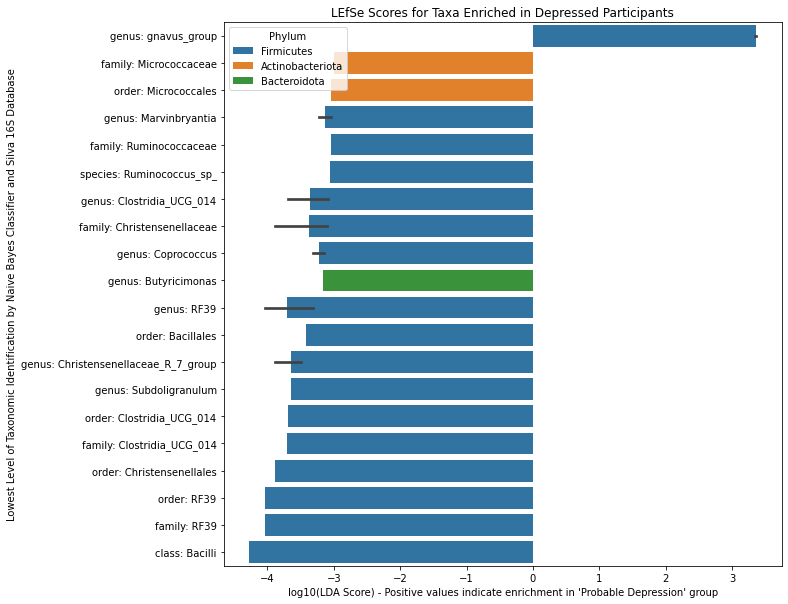

In [285]:
ax = sns.barplot(y="plotnames",
                 x="LDA Score (log10)",
                 hue = "Phylum",
                 data = lefse.loc[(lefse["LDA Score (log10)"] < -3) | (lefse["LDA Score (log10)"] > 2.5)], 
                 dodge=False,)

ax.set_ylabel("Lowest Level of Taxonomic Identification by Naive Bayes Classifier and Silva 16S Database")
ax.set_title("LEfSe Scores for Taxa Enriched in Depressed Participants")
ax.set_xlabel("log10(LDA Score) - Positive values indicate enrichment in 'Probable Depression' group")
plt.gcf().set_size_inches(10,10)
plt.show()

In [286]:
lefse = lefse[lefse["plotnames"].isna()==False]

In [287]:
cesdlefse = lefse

In [288]:
lefse.to_csv("lefse_cesd_plotdata.csv")

# Chemo Results

In [289]:
lefse = pd.read_csv("lefse_chemo_out.lefse_internal_res", 
                    sep="\t", 
                    header=None)

lefse.rename(mapper={0: "Bacteria",
                     1: "Log10(highest class average)",
                     2: "Highest Class",
                     3: "LDA Score (log10)",
                     4: "p value"},
             axis=1, inplace=True)

In [290]:
#filter only significant results
lefse = lefse.loc[lefse["Highest Class"].isna()==False]

#apply plotnames
lefse.loc[:,"plotnames"] = lefse.loc[:,"Bacteria"].apply(func=lambda x: make_plotnames(x))

In [291]:
lefse.loc[:,'tax_split'] =lefse.loc[:,'Bacteria'].apply(taxonomy_splitter, splitter=".")

lefse.loc[:,'Domain'] = lefse.loc[:,'tax_split'].apply(lambda x: x[0])
lefse.loc[:,'Phylum'] = lefse.loc[:,'tax_split'].apply(lambda x: x[1])
lefse.loc[:,'Class'] = lefse.loc[:,'tax_split'].apply(lambda x: x[2])
lefse.loc[:,'Order'] = lefse.loc[:,'tax_split'].apply(lambda x: x[3])
lefse.loc[:,'Family'] = lefse.loc[:,'tax_split'].apply(lambda x: x[4])
lefse.loc[:,'Genus'] = lefse.loc[:,'tax_split'].apply(lambda x: x[5])
lefse.loc[:,'Species'] = lefse.loc[:,'tax_split'].apply(lambda x: x[6])
lefse.drop('tax_split', axis=1, inplace=True)

lefse.loc[lefse["Highest Class"]=="2 - No","LDA Score (log10)"] = lefse.loc[lefse["Highest Class"]=="2 - No","LDA Score (log10)"].apply(lambda x: -1*x)

lefse.sort_values("LDA Score (log10)", ascending=False, inplace=True)


In [292]:
lefse = lefse.loc[lefse["plotnames"]!="genus: coprostanoligenes_group"]

In [293]:
lefse.loc[(lefse["LDA Score (log10)"] < -2.5) | (lefse["LDA Score (log10)"] > 2)]

,Bacteria,Log10(highest class average),Highest Class,LDA Score (log10),p value,plotnames,Domain,Phylum,Class,Order,Family,Genus,Species
107,d__Bacteria.p__Bacteroidota.c__Bacteroidia.o__...,4.298953,1 - Yes,4.096631,0.0410394676386,genus: Prevotellaceae_NK3B31_group,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotellaceae_NK3B31_group,
595,d__Bacteria.p__Bacteroidota.c__Bacteroidia.o__...,3.749163,1 - Yes,3.488088,0.0214007185983,species: Bacteroides_caccae,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides_caccae
225,d__Bacteria.p__Firmicutes.c__Clostridia.o__Lac...,3.373233,1 - Yes,3.121933,0.0410394676386,genus: Moryella,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Moryella,uncultured_organism
31,d__Bacteria.p__Proteobacteria.c__Gammaproteoba...,3.314307,1 - Yes,2.974844,0.0161133635427,family: Pasteurellaceae,Bacteria,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,NA,NA
320,d__Bacteria.p__Proteobacteria.c__Gammaproteoba...,3.314307,1 - Yes,2.963400,0.0161133635427,order: Pasteurellales,Bacteria,Proteobacteria,Gammaproteobacteria,Pasteurellales,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,d__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,4.071702,2 - No,-3.797132,0.0435224810006,order: Clostridia_UCG_014,Bacteria,Firmicutes,Clostridia,Clostridia_UCG_014,NA,NA,NA
854,d__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,4.071702,2 - No,-3.798453,0.0435224810006,family: Clostridia_UCG_014,Bacteria,Firmicutes,Clostridia,Clostridia_UCG_014,Clostridia_UCG_014,NA,NA
1145,d__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,4.071702,2 - No,-3.799481,0.0435224810006,genus: Clostridia_UCG_014,Bacteria,Firmicutes,Clostridia,Clostridia_UCG_014,Clostridia_UCG_014,Clostridia_UCG_014,NA
636,d__Bacteria.p__Bacteroidota.c__Bacteroidia.o__...,4.599334,2 - No,-3.946347,0.0204388003323,genus: Prevotella,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,NA


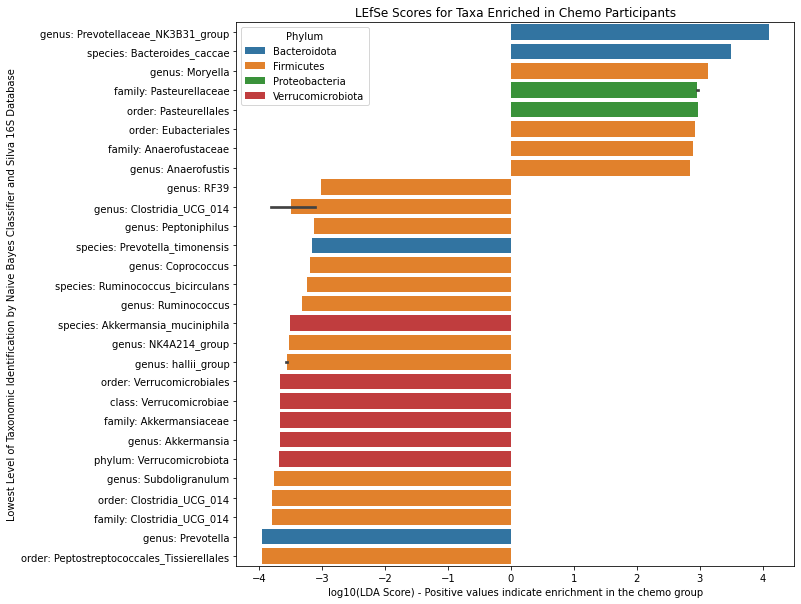

In [294]:
ax = sns.barplot(y="plotnames",
                 x="LDA Score (log10)",
                 hue = "Phylum",
                 data = lefse.loc[(lefse["LDA Score (log10)"] < -3) | (lefse["LDA Score (log10)"] > 2)], 
                 dodge=False,)

ax.set_ylabel("Lowest Level of Taxonomic Identification by Naive Bayes Classifier and Silva 16S Database")
ax.set_title("LEfSe Scores for Taxa Enriched in Chemo Participants")
ax.set_xlabel("log10(LDA Score) - Positive values indicate enrichment in the chemo group")
plt.gcf().set_size_inches(10,10)
plt.show()

In [295]:
chemolefse = lefse

In [296]:
lefse.to_csv("lefse_chemo_plotdata.csv")

## Fact-Cog

In [297]:
lefse = pd.read_csv("lefse_fact_out.lefse_internal_res", 
                    sep="\t", 
                    header=None)

lefse.rename(mapper={0: "Bacteria",
                     1: "Log10(highest class average)",
                     2: "Highest Class",
                     3: "LDA Score (log10)",
                     4: "p value"},
             axis=1, inplace=True)

In [298]:
#filter only significant results
lefse = lefse.loc[lefse["Highest Class"].isna()==False]

#apply plotnames
lefse.loc[:,"plotnames"] = lefse.loc[:,"Bacteria"].apply(func=lambda x: make_plotnames(x))

In [299]:
lefse.loc[:,'tax_split'] =lefse.loc[:,'Bacteria'].apply(taxonomy_splitter, splitter=".")

lefse.loc[:,'Domain'] = lefse.loc[:,'tax_split'].apply(lambda x: x[0])
lefse.loc[:,'Phylum'] = lefse.loc[:,'tax_split'].apply(lambda x: x[1])
lefse.loc[:,'Class'] = lefse.loc[:,'tax_split'].apply(lambda x: x[2])
lefse.loc[:,'Order'] = lefse.loc[:,'tax_split'].apply(lambda x: x[3])
lefse.loc[:,'Family'] = lefse.loc[:,'tax_split'].apply(lambda x: x[4])
lefse.loc[:,'Genus'] = lefse.loc[:,'tax_split'].apply(lambda x: x[5])
lefse.loc[:,'Species'] = lefse.loc[:,'tax_split'].apply(lambda x: x[6])
lefse.drop('tax_split', axis=1, inplace=True)

lefse.loc[lefse["Highest Class"]=="low","LDA Score (log10)"] = lefse.loc[lefse["Highest Class"]=="low","LDA Score (log10)"].apply(lambda x: -1*x)

lefse.sort_values("LDA Score (log10)", ascending=False, inplace=True)


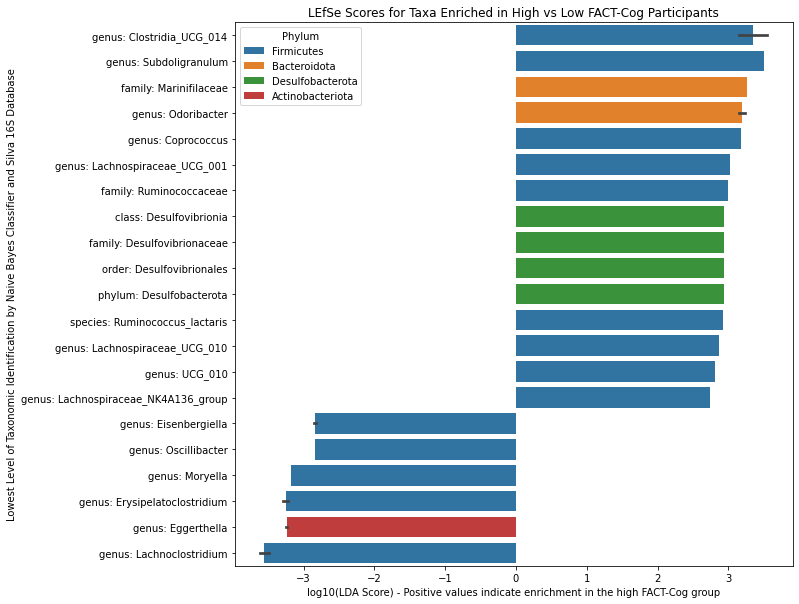

In [300]:
ax = sns.barplot(y="plotnames",
                 x="LDA Score (log10)",
                 hue = "Phylum",
                 data = lefse.loc[(lefse["LDA Score (log10)"] < -2) | (lefse["LDA Score (log10)"] > 2)], 
                 dodge=False,)

ax.set_ylabel("Lowest Level of Taxonomic Identification by Naive Bayes Classifier and Silva 16S Database")
ax.set_title("LEfSe Scores for Taxa Enriched in High vs Low FACT-Cog Participants")
ax.set_xlabel("log10(LDA Score) - Positive values indicate enrichment in the high FACT-Cog group")
plt.gcf().set_size_inches(10,10)
plt.show()

# Finding common microbes

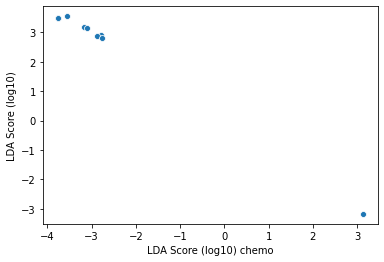

In [342]:
shared = list(set(lefse["Bacteria"]).intersection(set(chemolefse["Bacteria"])))

fact_chemo = lefse.loc[lefse["Bacteria"].apply(lambda x: x in shared)]
fact_chemo.loc[:,"Chemo_cat"] = chemolefse.loc[:,"Highest Class"]
fact_chemo.loc[:,"LDA Score (log10) chemo"] = chemolefse.loc[:,"LDA Score (log10)"]

scatter = fact_chemo[["Bacteria","LDA Score (log10)","LDA Score (log10) chemo", "plotnames"]]

ax = sns.scatterplot(x="LDA Score (log10) chemo",
                     y="LDA Score (log10)",
                     data=scatter)

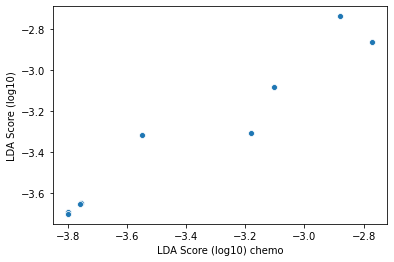

In [341]:
shared = list(set(cesdlefse["Bacteria"]).intersection(set(chemolefse["Bacteria"])))

cesd_chemo = cesdlefse.loc[cesdlefse["Bacteria"].apply(lambda x: x in shared)]
cesd_chemo.loc[:,"Chemo_cat"] = chemolefse.loc[:,"Highest Class"]
cesd_chemo.loc[:,"LDA Score (log10) chemo"] = chemolefse.loc[:,"LDA Score (log10)"]

scatter = cesd_chemo[["Bacteria","LDA Score (log10)","LDA Score (log10) chemo", "plotnames"]]

ax = sns.scatterplot(x="LDA Score (log10) chemo",
                     y="LDA Score (log10)",
                     data=scatter)

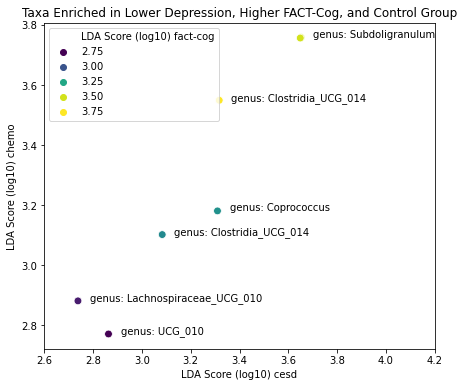

In [418]:
shared = set(lefse["Bacteria"]).intersection(set(chemolefse["Bacteria"])).intersection(cesdlefse["Bacteria"])

allshared = lefse.loc[lefse["Bacteria"].apply(lambda x: x in shared)]

allshared.loc[:,"Chemo_cat"] = chemolefse.loc[:,"Highest Class"]
allshared.loc[:,"LDA Score (log10) chemo"] = chemolefse.loc[:,"LDA Score (log10)"].apply(lambda x: x*-1)

allshared.loc[:,"Chemo_cesd"] = cesdlefse.loc[:,"Highest Class"]
allshared.loc[:,"LDA Score (log10) cesd"] = cesdlefse.loc[:,"LDA Score (log10)"].apply(lambda x: x*-1)

allshared.loc[:,"LDA Score (log10) fact-cog"] = allshared.loc[:,"LDA Score (log10)"]



ax = sns.scatterplot(x="LDA Score (log10) cesd",
                    y="LDA Score (log10) chemo",
                    hue="LDA Score (log10) fact-cog",
                    data=allshared,
                    palette="viridis",
                    s=60)
ax.set_title("Taxa Enriched in Lower Depression, Higher FACT-Cog, and Control Group")

#Adding bacteria names, drop 671 was to prevent slightly offset repeat of "genus: Subdoligranulum"
for i, bac in enumerate(allshared.drop(671)["plotnames"]):
    plt.text(x=allshared.drop(671)["LDA Score (log10) cesd"].iloc[i]+0.05,
             y=allshared.drop(671)["LDA Score (log10) chemo"].iloc[i],
             s=bac)

ax.set_xlim(2.6,4.2)
plt.gcf().set_size_inches(7,6)
plt.show()

#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')

#ax.plot(xs=allshared.loc[:,"LDA Score (log10) cesd"],
#        ys=allshared.loc[:,"LDA Score (log10) chemo"],
#        zs=allshared.loc[:,"LDA Score (log10)"],
#        marker="o")

In [411]:
allshared

,Bacteria,Log10(highest class average),Highest Class,LDA Score (log10),p value,plotnames,Domain,Phylum,Class,Order,Family,Genus,Species,Chemo_cat,LDA Score (log10) chemo,Chemo_cesd,LDA Score (log10) cesd,LDA Score (log10) fact-cog
53,d__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,3.778722,high,3.549433,0.0141849434845,genus: Clostridia_UCG_014,Bacteria,Firmicutes,Clostridia,Clostridia_UCG_014,Clostridia_UCG_014,Clostridia_UCG_014,,2 - No,3.548925,Possible_Depression,3.316972,3.549433
259,d__Bacteria.p__Firmicutes.c__Clostridia.o__Osc...,4.200195,high,3.501775,0.0251357643071,genus: Subdoligranulum,Bacteria,Firmicutes,Clostridia,Oscillospirales,Ruminococcaceae,Subdoligranulum,NA,2 - No,3.757990,Possible_Depression,3.651827,3.501775
671,d__Bacteria.p__Firmicutes.c__Clostridia.o__Osc...,4.199176,high,3.499730,0.0251357643071,genus: Subdoligranulum,Bacteria,Firmicutes,Clostridia,Oscillospirales,Ruminococcaceae,Subdoligranulum,,2 - No,3.756117,Possible_Depression,3.648870,3.499730
11,d__Bacteria.p__Firmicutes.c__Clostridia.o__Lac...,3.769446,high,3.178360,0.0186346707912,genus: Coprococcus,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Coprococcus,NA,2 - No,3.180847,Possible_Depression,3.309755,3.178360
250,d__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,3.307702,high,3.155453,0.00912455670065,genus: Clostridia_UCG_014,Bacteria,Firmicutes,Clostridia,Clostridia_UCG_014,Clostridia_UCG_014,Clostridia_UCG_014,uncultured_Acetivibrio,2 - No,3.102056,Possible_Depression,3.083465,3.155453
45,d__Bacteria.p__Firmicutes.c__Clostridia.o__Lac...,2.586020,high,2.863071,0.0217081946356,genus: Lachnospiraceae_UCG_010,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Lachnospiraceae_UCG_010,uncultured_organism,2 - No,2.881420,Possible_Depression,2.738264,2.863071
850,d__Bacteria.p__Firmicutes.c__Clostridia.o__Osc...,2.983600,high,2.806075,0.00818573249914,genus: UCG_010,Bacteria,Firmicutes,Clostridia,Oscillospirales,UCG_010,UCG_010,uncultured_bacterium,2 - No,2.771279,Possible_Depression,2.863329,2.806075


In [377]:
[x for x in allshared["Bacteria"]]

['d__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridia_UCG_014.f__Clostridia_UCG_014.g__Clostridia_UCG_014.__',
 'd__Bacteria.p__Firmicutes.c__Clostridia.o__Oscillospirales.f__Ruminococcaceae.g__Subdoligranulum',
 'd__Bacteria.p__Firmicutes.c__Clostridia.o__Oscillospirales.f__Ruminococcaceae.g__Subdoligranulum.__',
 'd__Bacteria.p__Firmicutes.c__Clostridia.o__Lachnospirales.f__Lachnospiraceae.g__Coprococcus',
 'd__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridia_UCG_014.f__Clostridia_UCG_014.g__Clostridia_UCG_014.s__uncultured_Acetivibrio',
 'd__Bacteria.p__Firmicutes.c__Clostridia.o__Lachnospirales.f__Lachnospiraceae.g__Lachnospiraceae_UCG_010.s__uncultured_organism',
 'd__Bacteria.p__Firmicutes.c__Clostridia.o__Oscillospirales.f__UCG_010.g__UCG_010.s__uncultured_bacterium']

Cool! The bacteria listed above are enriched in the controls, lower depression group, and . . . high fact cog? I thought emily said higher fact cog was associated with more dysfunction?

In [435]:
alls = lefse[["Bacteria", "plotnames","Highest Class", "LDA Score (log10)"]]

alls.loc[:,"Chemo_cat"] = chemolefse.loc[:,"Highest Class"]
alls.loc[:,"LDA Score (log10) chemo"] = chemolefse.loc[:,"LDA Score (log10)"]

alls.loc[:,"Cesd_cat"] = cesdlefse.loc[:,"Highest Class"]
alls.loc[:,"LDA Score (log10) cesd"] = cesdlefse.loc[:,"LDA Score (log10)"]

alls.loc[:,"LDA Score (log10) fact cog"] = lefse.loc[:,"LDA Score (log10)"].apply(lambda x: x*-1)

alls.set_index("plotnames",inplace=True)

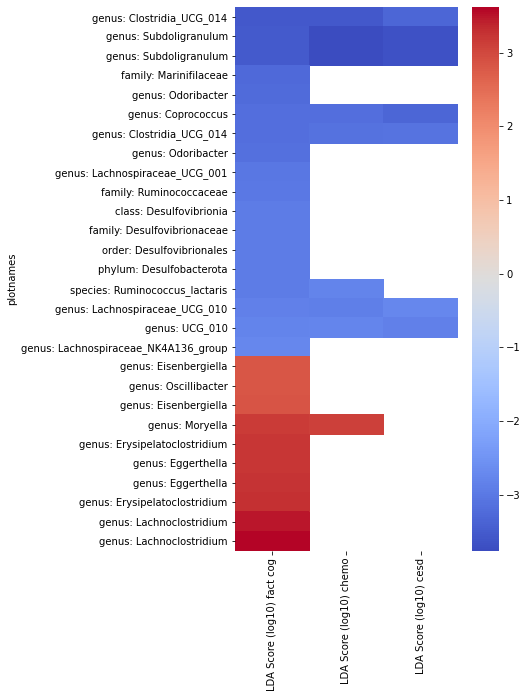

In [436]:
sns.heatmap(alls[["LDA Score (log10) fact cog", "LDA Score (log10) chemo", "LDA Score (log10) cesd"]],
            cmap="coolwarm",
           yticklabels=True)
plt.gcf().set_size_inches(5,10)
plt.show()

In [440]:
pd.concat([lefse[["plotnames", "Highest Class", "LDA Score (log10)"]],
            chemolefse.loc[:,["Highest Class", "LDA Score (log10)"]],
            cesdlefse.loc[:,["Highest Class", "LDA Score (log10)"]]],
         axis=1)

,plotnames,Highest Class,LDA Score (log10),Highest Class,LDA Score (log10),Highest Class,LDA Score (log10)
11,genus: Coprococcus,high,3.178360,2 - No,-3.180847,Possible_Depression,-3.309755
12,NaN,NaN,NaN,NaN,NaN,Possible_Depression,-2.752667
20,NaN,NaN,NaN,2 - No,-3.505035,NaN,NaN
30,NaN,NaN,NaN,2 - No,-2.738275,NaN,NaN
31,NaN,NaN,NaN,1 - Yes,2.974844,NaN,NaN
...,...,...,...,...,...,...,...
1118,genus: Eggerthella,low,-3.238075,NaN,NaN,NaN,NaN
1128,class: Desulfovibrionia,high,2.941570,NaN,NaN,NaN,NaN
1144,genus: Odoribacter,high,3.148965,NaN,NaN,NaN,NaN
1145,NaN,NaN,NaN,2 - No,-3.799481,Possible_Depression,-3.694472


## Getting relative abundances

In [196]:
of_interest = lefse["Bacteria"].apply(lambda x: "|".join(x.split(".")))

def fixtax(string):
    while sum("|"==c for c in string) < 6:
        string+="|__"
    return string

of_interest = of_interest.apply(fixtax)

of_interest_df = tax_df.loc[:,
                         [x for x in of_interest]]

I'm not quite sure what LEfSe is doing, but there are some LEfSe output bacteria that aren't present in our input data. I guess it groups by taxonomic level.

In [239]:
for col in of_interest_df.columns:
    #if sum(of_interest_df[col].isna()) >0:   
    try:
        if sum(of_interest_df[col].isna()) > 0:
            print(col)
    except TypeError:
        pass
    
#sum(of_interest_df["d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Moryella|s__uncultured_organism"].isna())

d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|__|__|__
d__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|__|__|__
d__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Anaerofustaceae|__|__
d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__UCG_010|g__UCG_010|__
d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Lachnospiraceae_NK4B4_group|__
d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__UCG_010|g__UCG_010|s__uncultured_bacterium
d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g___Ruminococcus__torques_group|s__Ruminococcus_lactaris
d__Bacteria|p__Firmicutes|c__Clostridia|o__uncultured|f__uncultured|g__uncultured|__
d__Bacteria|p__Firmicutes|c__Clostridia|o__uncultured|f__uncultured|__|__
d__Bacteria|p__Firmicutes|c__Clostridia|o__uncultured|__|__|__
d__Bacteria|p__Firmicutes|c__uncultured|o__uncultured|f__uncultured|g__uncultured|__
d__Bacteria|p__Bacteroidota|c__

In [240]:
for col in tax_df.columns:
    if col.startswith("d__Bacteria|p__Verrucomicrobiota|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae"):
        print(col)

d__Bacteria|p__Verrucomicrobiota|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|__
d__Bacteria|p__Verrucomicrobiota|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__Akkermansia_muciniphila
d__Bacteria|p__Verrucomicrobiota|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__Akkermansia_sp.
d__Bacteria|p__Verrucomicrobiota|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__uncultured_organism


In [245]:
tax_df.loc["Kingdom",:]=[taxonomy_splitter(x,"|")[0] for x in tax_df.columns]
tax_df.loc["Phylum",:]=[taxonomy_splitter(x,"|")[1] for x in tax_df.columns]
tax_df.loc["Class",:]=[taxonomy_splitter(x,"|")[2] for x in tax_df.columns]
tax_df.loc["Order",:]=[taxonomy_splitter(x,"|")[3] for x in tax_df.columns]
tax_df.loc["Family",:]=[taxonomy_splitter(x,"|")[4] for x in tax_df.columns]
tax_df.loc["Genus",:]=[taxonomy_splitter(x,"|")[5] for x in tax_df.columns]
tax_df.loc["Species",:]=[taxonomy_splitter(x,"|")[6] for x in tax_df.columns]